In [0]:
!pip3 install --quiet "tensorflow>=1.11"
!pip3 install --quiet sentencepiece

    100% |████████████████████████████████| 3.2MB 10.3MB/s 
    100% |████████████████████████████████| 1.0MB 19.5MB/s 


In [0]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import sentencepiece
import zipfile
from google.colab import auth
from google.colab import files
from IPython.display import HTML, display

Use Kaggle's My Account page to down load a kaggle.json file and re-upload it here.

In [0]:
!mkdir -p /root/.kaggle
token_file = "/root/.kaggle/kaggle.json"
uploaded = files.upload()
with open(token_file, "wb") as f:
  f.write(uploaded["kaggle.json"])
  os.chmod(token_file, 600)

Saving kaggle.json to kaggle.json


In [0]:
import kaggle

Download the test set and extract the labeled portion

In [0]:
kaggle.api.competition_download_file('jigsaw-toxic-comment-classification-challenge', 'test.csv')

 21%|██▏       | 5.00M/23.4M [00:00<00:00, 29.0MB/s]

100%|██████████| 23.4M/23.4M [00:00<00:00, 53.3MB/s]

In [0]:
kaggle.api.competition_download_file('jigsaw-toxic-comment-classification-challenge', 'test_labels.csv')

100%|██████████| 1.46M/1.46M [00:00<00:00, 119MB/s]

In [0]:
test_labels = pd.read_csv('test_labels.csv.zip', index_col='id')
testset = test_labels.loc[test_labels['toxic'] != -1].join(
  pd.read_csv('test.csv.zip', index_col='id'))

Load the pre-trained toxicity model from Google Cloud Storage

In [0]:
auth.authenticate_user()

In [0]:
!mkdir -p tfjs_model
!gsutil -m cp -R gs://conversationai-public/public_models/tfjs/v1/* tfjs_model

Copying gs://conversationai-public/public_models/tfjs/v1/saved_model.pb...
Copying gs://conversationai-public/public_models/tfjs/v1/assets/universal_encoder_8k_spm.model...
Copying gs://conversationai-public/public_models/tfjs/v1/variables/variables.data-00000-of-00001...
Copying gs://conversationai-public/public_models/tfjs/v1/variables/variables.index...


In [0]:
predict_fn = tf.contrib.predictor.from_saved_model(
  'tfjs_model', signature_def_key='predict')



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tfjs_model/variables/variables


Load sentence piece model and preprocess test data

In [0]:
sp = sentencepiece.SentencePieceProcessor()
sp.Load('tfjs_model/assets/universal_encoder_8k_spm.model')

True

Score the sentences with toxicity model

In [0]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
tox_scores = []
nrows = testset.shape[0]
out = display(progress(0, nrows), display_id=True)
for offset in range(0, nrows):
  out.update(progress(offset, nrows))
  values = sp.EncodeAsIds(testset['comment_text'][offset])
  tox_scores.append(predict_fn({
      'values': values,
      'indices': [(0, i) for i in range(len(values))],
      'dense_shape': [1, len(values)]})['toxicity/probabilities'][0,1])

In [0]:
!gsutil cp gs://conversationai-public/public_models/tfjs/perspectiveapi.csv .

Copying gs://conversationai-public/public_models/tfjs/perspectiveapi.csv...
/ [1 files][  2.0 MiB/  2.0 MiB]                                                
Operation completed over 1 objects/2.0 MiB.                                      


In [0]:
perspective_api=pd.read_csv('perspectiveapi.csv')

In [0]:
top_kernel = kaggle.api.kernels_output(kernel='tunguz/superblend', path='.')

In [0]:
top_kernel_scores = testset = test_labels.loc[test_labels['toxic'] != -1].join(
  pd.read_csv('superblend.csv', index_col='id'), rsuffix='_predicted')

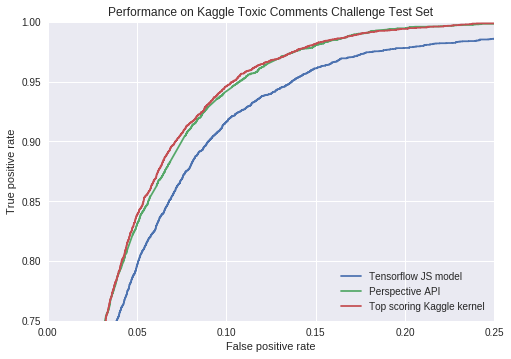

In [0]:
plt.figure()

fpr, tpr, _ = metrics.roc_curve(testset['toxic'], tox_scores)
plt.plot(fpr, tpr, label='Tensorflow JS model')

fpr, tpr, _ = metrics.roc_curve(testset['toxic'],
                                perspective_api['PerspectiveAPI'].values)
plt.plot(fpr, tpr, label='Perspective API')


fpr, tpr, _ = metrics.roc_curve(top_kernel_scores['toxic'],
                                top_kernel_scores['toxic_predicted'])
plt.plot(fpr, tpr, label='Top scoring Kaggle kernel')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.ylim(0.75, 1.0)
plt.xlim(0.0, 0.25)
plt.title('Performance on Kaggle Toxic Comments Challenge Test Set')
plt.show()
